In [23]:
import numpy as np
import torch
import torch.nn as nn
from data_init import class_incremental, Data_Init
from model_config import MyModel_Config
from pytorch_pretrained_bert import BertConfig, BertTokenizer, BertModel, BertForMaskedLM
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt   #jupyter要matplotlib.pyplot
from torch.utils.data import DataLoader, Dataset, TensorDataset
import random
from train_eval import Model_Train
import re
from tqdm import *
import pandas as pd
from pandas import DataFrame
from torch.distributions import Dirichlet

In [24]:
'''调整随机数'''
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(5)

In [25]:
'''利用增量数据初始化处理数据集'''
train_incremental = class_incremental('./data/snips/train.tsv', 'tsv', 64, 7, 5, True, 9999999) #最后的500表示每个类的数据个数限制
train_original_datas, train_incremental_datas_list, train_original_labels, train_all_incremental_labels, labels, label_to_idx = train_incremental.prepare_for_incremental()
train_Joint_datasets = train_incremental.Joint_incremental()

#初始化验证集的原始类和增量类数据
dev_incremental = class_incremental('./data/snips/dev.tsv', 'tsv', 64, 7, 5, True, 999999, 'eval', labels, label_to_idx)
dev_original_datas, dev_incremental_datas_list, dev_original_labels, dev_all_incremental_labels = dev_incremental.prepare_for_incremental()
dev_Joint_datasets = dev_incremental.Joint_incremental()

#初始化测试集的原始类和增量类数据
test_incremental = class_incremental('./data/snips/test.tsv', 'tsv', 64, 7, 5, True, 9999999, 'eval', labels, label_to_idx)
test_original_datas, test_incremental_datas_list, test_original_labels, test_all_incremental_labels = test_incremental.prepare_for_incremental()
test_Joint_datasets = test_incremental.Joint_incremental()

In [26]:
'''定义训练模型'''
class Teachermodel(nn.Module):
    def __init__(self,config):
        super(Teachermodel,self).__init__()
        self.bert=BertModel.from_pretrained(config.bert_path)  
        for param in self.bert.parameters():
            param.requires_grad = True
 
        
        self.dropout=nn.Dropout(config.dropout)

        self.fc = nn.Linear(768, config.num_classes ) 


    def forward(self, tokens):

        encoder_out,pooled = self.bert(tokens,output_all_encoded_layers=False) 
     
        out=self.fc(encoder_out[:,0,:])
 
        out = self.dropout(out)
        
        return out


'''定义Bert生成模型。通过在一个OOD数据集训练让其输入噪声后可以输出在该OOD上的词汇集'''
class Bert_Gen(nn.Module):  #Bert生成模型
    def __init__(self, Bert_config): #tokens_len表示生成数据的长度,即最后bert要生成这么长的文本
        super(Bert_Gen,self).__init__()
        self.device = Bert_config.device
        
        self.bert1=BertModel.from_pretrained(Bert_config.bertmini_path)  #从路径加载预训练模型
        for param in self.bert1.parameters():
            param.requires_grad = True # 使参数可更新
        
        self.fc3= nn.Linear(Bert_config.hidden_size, 1024)
        self.fc4 = nn.Linear(1024, 30522)
    
    def forward(self, z): #tokens表示dataloader中的一个batch的tokens，即去掉label部分的token tensor
        

        out = z.long()#将经过线性层将正态分布z变为long型整数输入到bert
        
        encoder_out, pool = self.bert1(out.view(1,-1), output_all_encoded_layers=False) #得到每个token的向量表示
        
        out = self.fc3(encoder_out.squeeze())  
        out = F.relu(out)
        out = self.fc4(out)  #经过线性层处理生成新的向量，和bert词表大小相同
        out = F.gumbel_softmax(out, 10, True)
        
        return out  #输出一个batch的softmax [batch_size, 类别的softmax得分]


'''用于生成DI数据印象的模型'''
class DI_Gen_model(nn.Module):
    def __init__(self, teacher_model):
        super(DI_Gen_model,self).__init__()
        
        self.bert_gen = torch.load('./model/bert_genMINI3')
        for param in self.bert_gen.parameters():    
            param.requires_grad = True
            
        self.bert_cnn = teacher_model
        for param in self.bert_cnn.parameters():    
            param.requires_grad = False
            
    def forward(self, z):
        
        
        tokens = self.bert_gen(z)
        tokens = torch.argmax(tokens, dim=1, keepdim=False).long().view(1,-1)
        
        tokens = tokens.squeeze().tolist()
        tokens.append(102)#添加sep符号
        tokens.insert(0, 101) #添加cls符号
        tokens = torch.tensor(tokens).view(1,-1).to('cuda:0')  #感觉加了之后要好一些
        
        self.bert_cnn.eval()
        out = self.bert_cnn(tokens) #输入(batch_size=1, token_len)的tokens, 输出(batch_size=1, num_classes)的out
        
        return out, tokens



In [27]:
'''student模型'''
class Bert_student(nn.Module):
    def __init__(self,config):
        super(Bert_student,self).__init__()
        self.bert=BertModel.from_pretrained(config.bertmini_path)  
        for param in self.bert.parameters():
            param.requires_grad = True
        
        self.dropout=nn.Dropout(config.dropout)
        self.fc = nn.Linear(256, config.num_classes ) 


    def forward(self, tokens):

    
        encoder_out,pooled = self.bert(tokens,output_all_encoded_layers=False) 
        out=self.fc(encoder_out[:,0,:])
        out = self.dropout(out)
        
        return out

In [28]:
class Model_Train_ipynb(object):
    def __init__(self, isTPCIL=False): #
        #self.epochs = MyModel_Config.epochs #训练几个epochs
        self.device = 'cuda:0'
        self.isTPCIL = isTPCIL
        
    '''测试集和验证集的精度计算,用于全体验证集或测试集的精度计算
    model：要评估的模型
    datapath：输入字符串如'./data/snips/valid.csv'，表明要测试的验证集或测试集路径
    mode:输入字符串'csv'或'tsv' ，表明要测试的文件格式'''
    def my_eval(self, model, datapath, loss_func, mode, label_to_idx_train):
        device = self.device
        tensor_datas, labels_idx = Data_Init(datapath, 64, mode, 'eval', label_to_idx_train).datas_to_tensors()#输出都是tensor形式

        model = model.to(device)
        model.eval() #eval()将我们的模型置于评估模式，而不是训练模式。在这种情况下，评估模式关闭了训练中使用的dropout正则化。
        accuracy=0
        loss_sum=0
        with torch.no_grad():
            for idx, datas in enumerate(tensor_datas):
                tokens = datas[0].to(device)  #tokens输入到bert里得到[batch_size, seq_len, embedding_size]的embedding
                labels_idx = datas[1].to(device)
                
                if self.isTPCIL == False:
                    probs = model(tokens).squeeze()  #去除掉[batch_size, 1, len(classes)]中的1维度
                elif self.isTPCIL == True:
                    _, probs = model(tokens)  #去除掉[batch_size, 1, len(classes)]中的1维度
                    probs.squeeze()
                loss = loss_func(probs, labels_idx) #"host_softmax" not implemented for 'Long'错误出现，如果预测值和标签写反
                #虽然这里的probs没有经过softmax处理，但也可以用下面的这个argmax公式，因为softmax不会改变原本数值元素的大小排名
                accuracy += (labels_idx == torch.argmax(probs, dim=1)).sum()  #计算预测标签和真实标签相等的数量
                loss_sum+=loss.item() #计算所有样本/batch的loss
                
                last_size = len(datas[1])  #用于保存最后一个batch有多少数据

        accuracy = accuracy / (idx*tensor_datas.batch_size + last_size)
        accuracy = accuracy.item()
        model.train()#从eval模式回到train模式

        return accuracy, loss_sum
    
    '''由于增量学习要求对相应的增量类和原始类数据进行精度的计算，所以如果直接输入验证集路径进去，会导致计算所有类精度，所以这里输入变为直接输入数据
    model:要进行精度计算的模型
tensor_datas:验证集/测试集的经过Dataloader封装的数据
loss_function:用于计算验证集/测试集损失'''

    def eval_for_incremental(self, model, tensor_datas, loss_function):
        device = self.device
        model = model.to(device)

        accuracy=0
        loss_sum=0
    
        model.eval() #关闭模型dropout
        with torch.no_grad():
            idx = 0
            for idx, datas in enumerate(tensor_datas):
                tokens = datas[0].to(device)  #tokens输入到bert里得到[batch_size, seq_len, embedding_size]的embedding
                labels_idx = datas[1].to(device)
                
                if self.isTPCIL == False:
                    probs = model(tokens).squeeze()  #去除掉[batch_size, 1, len(classes)]中的1维度
                elif self.isTPCIL == True:
                    _, probs = model(tokens)  #去除掉[batch_size, 1, len(classes)]中的1维度
                    probs.squeeze()
                loss = loss_function(probs, labels_idx) #"host_softmax" not implemented for 'Long'错误出现，如果预测值和标签写反
            
                accuracy += (labels_idx == torch.argmax(probs, dim=1)).sum()  #计算预测标签和真实标签相等的数量
                loss_sum+=loss.item() #计算所有样本/batch的loss
                
                last_size = len(datas[1])  #用于保存最后一个batch有多少数据

        accuracy = float(accuracy) / (idx*tensor_datas.batch_size + last_size)

        model.train()#从eval模式回到train模式

        return accuracy, loss_sum
#用法：
#eval_for_incremental(model, tensor_datas, loss_function),用法在incremental_learning文件的类中


    '''参数：
    model：训练模型
    loss_func:损失函数
    optimizer:优化器
    epochs:迭代次数
    tensor_datas:要输入的Dataloader封装的数据，默认为MyModel_Config里面的数据
    datapath_eval: 如果等于'none'说明不对验证集或测试集进行每个batch训练后的精度和损失计算；如果等于验证集或测试集路径，则进行计算
    eval_mode：验证集或测试集的格式，为'csv'或'tsv'.
    label_to_idx_train:训练集的标签字典，只有当datapath_eval不为none时候才设置初值'''
    def my_train(self, model, loss_func, optimizer, epochs, tensor_datas, datapath_eval='none', eval_mode='csv', label_to_idx_train={}): #增加了需要自己输入的epochs
        device = self.device
        #epochs = self.epochs
        model.train()

        model = model.to(device)
        losses = [] #存放所有样本一个epoch的损失
        accuracies = []
        iter = [] #用于绘图的横坐标

        #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)#每一轮epoch学习率递减
        for epoch in tqdm(range(epochs)):
            
            '''对每个batch的训练'''
            for idx, datas in enumerate(tensor_datas):  #idx表示第几个batch，datas为[batch_size, tokens, label]的数据
                tokens = datas[0].to(device)
                labels = datas[1].to(device)
                #labels_one_hot = datas[1].to(device)  #one-hot形式标签，用于损失计算，[batch_size, labels_nums]
                #labels = torch.topk(labels_one_hot, 1)[1].view(-1,1)   #要计算精度，就需要非one-hot形式的标签，转化为(batch_size,1)形式的标签
        
                optimizer.zero_grad() #新batch训练时将梯度归0，防止梯度累积
                if self.isTPCIL == False:
                    probs = model(tokens).squeeze()  #去除掉[batch_size, 1, len(classes)]中的1维度
                elif self.isTPCIL == True:
                    _, probs = model(tokens)  #去除掉[batch_size, 1, len(classes)]中的1维度
                    probs.squeeze()
                loss = loss_func(probs, labels) #"host_softmax" not implemented for 'Long'错误出现，如果预测值和标签写反
                loss.backward()
                optimizer.step()
                #scheduler.step()#学习率递减
            accuracy_train, loss_sum = self.eval_for_incremental(model, tensor_datas, loss_func)
    
            if datapath_eval != 'none': 
                if label_to_idx_train == {}:
                    raise ValueError("要输出测试集精度模式下需要输入训练集对应的标签字典")
                accuracy_eval, loss_eval = self.my_eval(model, datapath_eval, loss_func, eval_mode, label_to_idx_train)
                print('第'+str(epoch)+'的验证集失为：'+str(loss_eval))
                print('第'+str(epoch)+'的验证集精度为：'+str(accuracy_eval))
            
            accuracies.append(accuracy_train) #accuracy上的数据在cuda上，需要放到cpu上才能作图，而loss.item()已经加到cpu上了
            losses.append(loss_sum)
            iter.append(epoch)
            #print("the loss of  training data "+ str(epoch) + "  is-----------" + str(loss_sum))
            #print("the accuracy of training data   "+ str(epoch) + "  is-----------" + str(accuracy_train))
    
        #plt.figure(1)
        #plt.title("loss of epoch per————"+str(loss_func)+ ","+ str(epochs)+ "epochs")
        #plt.xlabel("loss per epoch")
        #plt.ylabel("LOSS")
        #plt.plot(iter, losses)

        #plt.figure(2)
        #plt.title("accuracy of epoch per————"+str(accuracy_train)+ ","+ str(epochs)+ "epochs")
        #plt.xlabel("accuracy per epoch")
        #plt.ylabel("ACCURACY")
        #plt.plot(iter, accuracies)

        #plt.show()
        return accuracies, losses

In [29]:
'''利用原始数据训练并保存Teacher model'''
print('*******************原始数据训练Teacher model**********************')
teacher_model = Teachermodel(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(teacher_model.parameters(), lr=1e-5)
loss_fuc = nn.CrossEntropyLoss()

'''训练模型，得到精度'''
accuracy_train, loss_train = Model_Train_ipynb().my_train(teacher_model, loss_fuc, optimizer, 10, train_original_datas)
accuracy_dev, loss_dev = Model_Train_ipynb().eval_for_incremental(teacher_model, dev_original_datas, loss_fuc)
accuracy_test, loss_test = Model_Train_ipynb().eval_for_incremental(teacher_model, test_original_datas, loss_fuc)
print('训练集精度变化'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))

*******************原始数据训练Teacher model**********************


100%|██████████| 10/10 [09:11<00:00, 55.16s/it]


训练集精度变化[0.9859068627450981, 0.9905790441176471, 0.9931832107843137, 0.9954810049019608, 0.9931832107843137, 0.9967830882352942, 0.9983915441176471, 0.9983149509803921, 0.9990042892156863, 0.9993872549019608]
验证集最终精度0.9875
测试集最终精度0.98125


In [30]:
'''利用原始数据训练并保存student model'''
print('*******************原始数据训练Teacher model**********************')
student_model = Bert_student(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-5)
loss_fuc = nn.CrossEntropyLoss()

'''训练模型，得到精度'''
accuracy_train, loss_train = Model_Train_ipynb().my_train(student_model, loss_fuc, optimizer, 10, train_original_datas)
accuracy_dev, loss_dev = Model_Train_ipynb().eval_for_incremental(student_model, dev_original_datas, loss_fuc)
accuracy_test, loss_test = Model_Train_ipynb().eval_for_incremental(student_model, test_original_datas, loss_fuc)
print('训练集精度变化'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))


*******************原始数据训练Teacher model**********************


100%|██████████| 10/10 [02:01<00:00, 12.13s/it]


训练集精度变化[0.934359681372549, 0.9654564950980392, 0.9760263480392157, 0.9816176470588235, 0.9832261029411765, 0.9862132352941176, 0.9872855392156863, 0.9892769607843137, 0.9896599264705882, 0.9919577205882353]
验证集最终精度0.9859375
测试集最终精度0.978125


In [31]:
last_layer_weight = teacher_model.fc.weight.detach().to('cpu')  #去除梯度
concent_params = torch.zeros([last_layer_weight.shape[0], last_layer_weight.shape[0]])
for i in range(len(last_layer_weight)):
    for j in range(len(last_layer_weight)):
        param = torch.matmul(last_layer_weight[i],last_layer_weight[j])
        param = param / (torch.norm(last_layer_weight[i]) * torch.norm(last_layer_weight[j]))  #计算最后一层权重的关系
        concent_params[i][j] = param
        
    max_val = torch.max(concent_params[i])
    min_val = torch.min(concent_params[i])
    concent_params[i] = (concent_params[i] - min_val + 1e-7) / (max_val-min_val)   #加上1e-7防止有0存在
    
labels = train_original_labels #绘图用到的标签

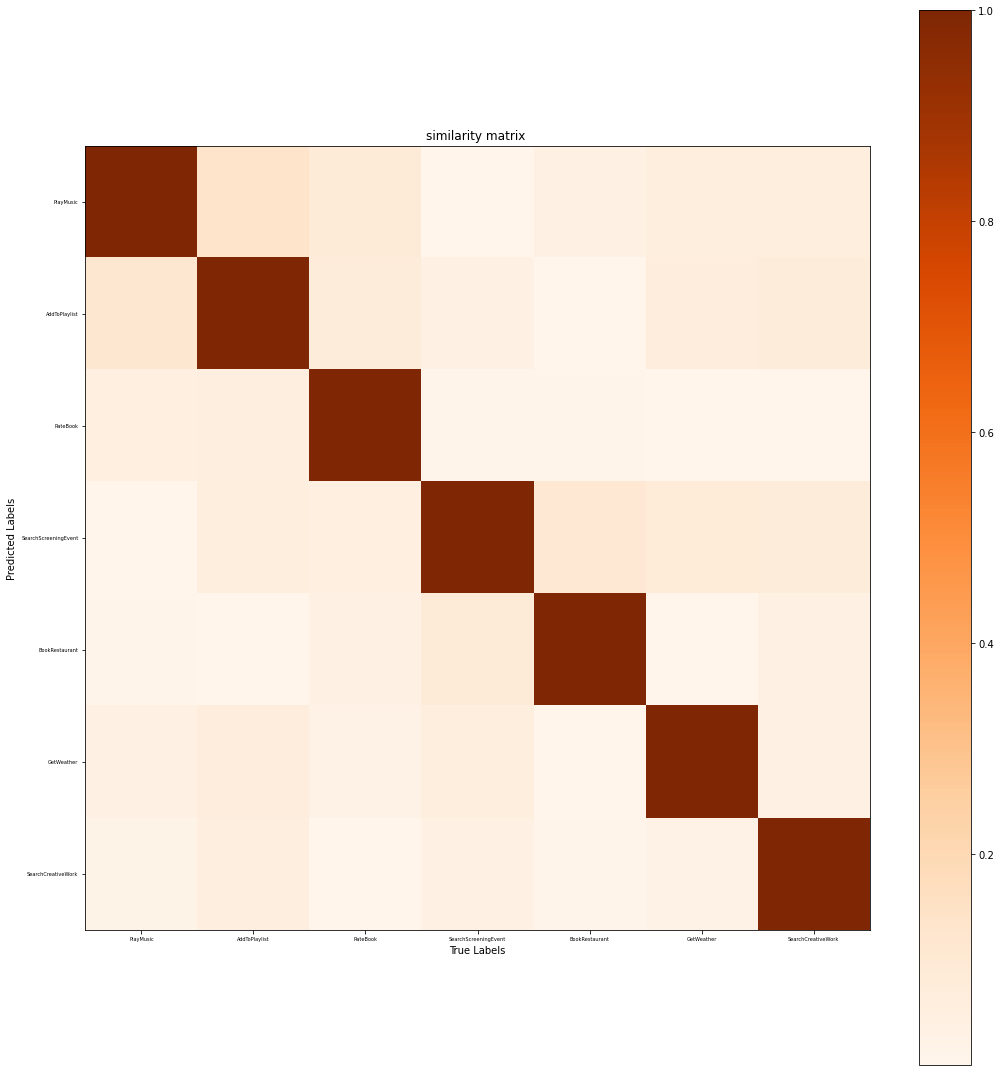

In [32]:
'''相似度矩阵绘制'''
def similar_matrix_plot(concent_params, num_classes, labels):#绘制混淆矩阵
    matrix = concent_params.numpy()  #先放在numpy上才能作图
    plt.figure(figsize=(15,15))  #设置画布大小
    plt.imshow(matrix, cmap=plt.cm.Oranges)
  
    # 设置x轴坐标label
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, labels,fontsize=5)
    plt.yticks(tick_marks, labels,fontsize=5)
        # 显示colorbar
    plt.colorbar()
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.title('similarity matrix ')

    plt.tight_layout()
    plt.show()

similar_matrix_plot(concent_params, len(train_original_labels), labels)

In [33]:
'''读取OOD的wiki103数据'''
import os
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, encoding='utf-8') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

paragraphs = _read_wiki('./wiki103')

'''将读取的wiki数据tokenize'''
tokenizer = BertTokenizer.from_pretrained('./bert-pretrained')
tokens = []
datas_size = len(paragraphs)
for l in tqdm(range(datas_size)):
    for k in range(len(paragraphs[l])):
        text = paragraphs[l][k]
        text = tokenizer.tokenize(text)
        token = tokenizer.convert_tokens_to_ids(text)
        tokens.append(token)

ood_num = 16000
ood_datas = []
temp = [[] for i in range(len(tokens))] #这样防止temp和tokens地址相同
for i in range(len(tokens)):
    temp[i] = tokens[i]
for i in range(ood_num):  #Bert最长读512最少读2长度的tokens,所以要处理
    if len(temp[i]) <98 and len(temp[i])>2:
        ood_datas.append(temp[i])
        
print(len(ood_datas))

100%|██████████| 760542/760542 [20:22<00:00, 622.04it/s]  


15774


In [34]:
'''训练DI生成模型'''
def train_DI_gen(dir_samples, ood_data, DI_gen, optimizer, loss_func, loss_func2, label, temper=10, error=1.4, max_iter=True):
    device = 'cuda:0'
    DI_gen = DI_gen.to(device)
    loss_num=999
    tokenizer = BertTokenizer.from_pretrained('./bert-pretrained')
    DI_gen.train()
    for i in range(len(dir_samples)):
        count = 0
        ood_data = ood_data.view(-1,1).to(device)
        #z = torch.randn(30,1).to(device)
        tokens_gens=torch.tensor([]).to(device) #选择最小损失的tokens
        losses = torch.tensor([]) #保存对应的损失
        while loss_num > error:  
            
            if max_iter == True and count>=300:  #是否设置最大迭代次数1200
                break
            
            optimizer.zero_grad()
            
            label = label.to(device).long()
            dir_sample = dir_samples[i].to(device).view(1,-1)
            
            probs, tokens_gen = DI_gen(ood_data)
            
            #loss = loss_func(F.log_softmax(probs / temper, dim=1), dir_sample)
            #loss = 0.6*loss_func2(probs, label)
            loss = loss_func(F.log_softmax(probs / temper, dim=1), dir_sample) + 0.6*loss_func2(probs, label) #如果不加后面的硬性指标会使得预测的标签混乱
            loss_num = loss.item()
            
            loss.requires_grad_(True) #这里应该是因为如果将最后一层的模型参数梯度关闭，则计算出来的loss也没有梯度，不能追踪，所以要将loss的梯度设置为True
            loss.backward()
            optimizer.step()
            count += 1
            
            if count%2==0:
                tokens_gens = torch.cat([tokens_gens, tokens_gen], dim=0)
                losses = torch.cat([losses, torch.tensor([loss_num])])
                #print(loss_num)
        #print('训练过程中bert_cnn的预测情况'+str(torch.argmax(probs)))
            
    if max_iter == True and len(tokens_gens) > 0:
        tokens_gen = tokens_gens[torch.argmin(losses).item()]  #选择loss最小的
            
    return tokens_gen
        

In [35]:
'''定义理想情况，DI数据应该对应的真实标签'''
DI_num = len(ood_datas)
DI_labels = torch.tensor([])
for i in range(len(train_original_labels)):
    for k in [1,5]:
        for j in range(int(DI_num/len(train_original_labels)/2)):
            DI_labels = torch.cat([DI_labels, torch.tensor([i])])

In [36]:
'''定义DI的生成模型，以及损失函数和优化器'''
DI_gen = DI_Gen_model(teacher_model)
loss_func = nn.KLDivLoss(reduction = 'mean')
loss_func2 = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(DI_gen.parameters(), lr=1e-5)

'''生成训练集的DI'''
DI_num = len(ood_datas)
DI_datas = torch.tensor([])
ood_idx = 0
for i in range(len(train_original_labels)):  #标签的idx刚好和train_original_labels的下标顺序对应

    for k in [0.5,0.8]:  #每种β生成1/2的数据
        m = Dirichlet(k*concent_params[i])  #采样每个类的数据
        
        for j in tqdm(range(int(DI_num/len(train_original_labels)/2))):
            x = m.sample().view(1,-1)
            
            DI_gen = DI_Gen_model(teacher_model)
            optimizer = torch.optim.SGD(DI_gen.parameters(), lr=1e-5)
            
            tokens = train_DI_gen(x, torch.tensor(ood_datas[ood_idx]), DI_gen, optimizer, loss_func, loss_func2, torch.tensor([i]))
            ood_idx += 1
            
            tokens = tokens.squeeze().tolist()
            while len(tokens)<100:
                tokens.append(0)  #padding到100
        
            tokens = torch.tensor(tokens)
            DI_datas = torch.cat([DI_datas, tokens.to('cpu').view(1,-1)], dim=0)
            
  


  0%|          | 0/1126 [00:00<?, ?it/s]/root/deepo/LYL/anaconda/ls/envs/csuse/lib/python3.7/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 1126/1126 [04:15<00:00,  4.41it/s]


In [37]:
'''随机测试DI对应的英文'''
tokenizer = BertTokenizer.from_pretrained('./bert-pretrained')
text = tokenizer.convert_ids_to_tokens(DI_datas[10].tolist())
print(text)

DI_datasets = TensorDataset(DI_datas.long())
DI_datasets = DataLoader(DI_datasets, batch_size=128, shuffle=False, drop_last=False, num_workers=2)

'''观察生成DI数据的预测标签特性'''
teacher_model.eval()
teacher_model = teacher_model.to('cuda:0')
DI_pred_labels = torch.tensor([])
with torch.no_grad():
    for i, data in enumerate(DI_datasets):
        out = teacher_model(data[0].to('cuda:0').long())
        DI_pred = torch.argmax(F.softmax(out), dim=1) #DI数据输入到bert_cnn中对应的标签
        DI_pred_labels = torch.cat([DI_pred_labels, DI_pred.to('cpu')])

DI_pred_dict = {} #记录DI预测的不同种类标签个数
for i in range(len(train_original_labels)):
    DI_pred_dict[i] = 0
for i in range(len(DI_pred_labels)):
    DI_pred_dict[DI_pred_labels[i].item()] += 1 
print(DI_pred_dict)

['[CLS]', '##pies', '##nett', '##iable', 'ara', 'victory', 'claus', '忠', 'undergone', '藤', 'acacia', 'sixteenth', '90s', 'entrepreneur', 'milos', 'bonnie', 'silvio', 'sub', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


/root/deepo/LYL/anaconda/ls/envs/csuse/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


{0: 562, 1: 8584, 2: 150, 3: 1338, 4: 948, 5: 696, 6: 3486}


In [38]:
'''将DI文件装入Dataloader中'''
DI_datasets = TensorDataset(DI_datas.long(), DI_pred_labels.long())
DI_datasets = DataLoader(DI_datasets, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

In [39]:
student_model.eval()
student_model = student_model.to('cuda:0')
with torch.no_grad():
    for i , data in enumerate(DI_datasets):
        test_output = student_model(data[0].to('cuda:0'))
        x = data[0]

In [40]:
print(torch.argmax(F.softmax(test_output, dim=1), dim=1))
indexs = torch.argmax(F.softmax(test_output, dim=1), dim=1).to('cpu')
print(F.softmax(test_output, dim=1))

tensor([6, 0, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 0, 0, 6, 6, 6, 6, 3, 6, 3, 0, 6, 0,
        6, 0, 0, 6, 3, 6, 6, 3, 6, 6, 6, 6, 6, 0, 2, 0, 3, 6, 3, 1, 6, 3, 1, 6,
        1, 6, 6, 0, 6, 6, 2, 0, 0, 0, 0, 3, 6, 6, 6, 0, 0, 1, 6, 0, 6, 0, 6, 6,
        6, 1, 6, 6, 0, 6, 6, 0, 3, 6, 6, 4, 0, 6, 3, 0, 1, 6, 3, 1, 0, 0, 6, 1,
        3, 1, 6, 6, 6, 6, 0, 6, 6, 3, 0, 6, 6, 6, 6, 1, 0, 6, 6, 6, 0, 6, 3, 1,
        6, 6, 6, 6, 6, 6, 6, 1], device='cuda:0')
tensor([[0.2010, 0.0630, 0.0619, 0.0419, 0.0117, 0.0192, 0.6013],
        [0.4994, 0.2625, 0.0220, 0.0270, 0.0349, 0.0212, 0.1330],
        [0.2304, 0.0640, 0.0654, 0.0372, 0.0510, 0.0363, 0.5158],
        [0.0167, 0.0089, 0.0037, 0.0157, 0.0021, 0.0101, 0.9428],
        [0.0742, 0.1276, 0.0529, 0.0958, 0.0184, 0.0173, 0.6137],
        [0.1463, 0.0460, 0.0119, 0.0202, 0.0236, 0.0065, 0.7455],
        [0.0714, 0.0225, 0.0441, 0.0425, 0.0125, 0.0163, 0.7908],
        [0.1343, 0.0924, 0.0911, 0.1272, 0.0358, 0.0163, 0.5029],
        [0.0337, 0.022

In [41]:
for i in range(len(indexs)):
    print(F.softmax(test_output, dim=1)[i][indexs[i]])

tensor(0.6013, device='cuda:0')
tensor(0.4994, device='cuda:0')
tensor(0.5158, device='cuda:0')
tensor(0.9428, device='cuda:0')
tensor(0.6137, device='cuda:0')
tensor(0.7455, device='cuda:0')
tensor(0.7908, device='cuda:0')
tensor(0.5029, device='cuda:0')
tensor(0.7683, device='cuda:0')
tensor(0.6069, device='cuda:0')
tensor(0.2901, device='cuda:0')
tensor(0.4878, device='cuda:0')
tensor(0.3603, device='cuda:0')
tensor(0.5415, device='cuda:0')
tensor(0.4732, device='cuda:0')
tensor(0.3965, device='cuda:0')
tensor(0.3463, device='cuda:0')
tensor(0.3702, device='cuda:0')
tensor(0.6293, device='cuda:0')
tensor(0.4588, device='cuda:0')
tensor(0.6678, device='cuda:0')
tensor(0.4892, device='cuda:0')
tensor(0.7764, device='cuda:0')
tensor(0.5585, device='cuda:0')
tensor(0.6190, device='cuda:0')
tensor(0.2973, device='cuda:0')
tensor(0.5118, device='cuda:0')
tensor(0.4225, device='cuda:0')
tensor(0.4031, device='cuda:0')
tensor(0.8288, device='cuda:0')
tensor(0.5814, device='cuda:0')
tensor(0

In [42]:
student_model.eval()
student_model = student_model.to('cuda:0')
with torch.no_grad():
    count = 0
    test_num = 0
    for i , data in enumerate(DI_datasets):
        test_output = student_model(data[0].to('cuda:0'))
        idxs = torch.argmax(F.softmax(test_output, dim=1), dim=1).to('cpu')
        for j in range(len(idxs)):
            if F.softmax(test_output, dim=1)[j][idxs[j]] > 0.50:
                count+=1
            test_num += 1
print(count)
print(test_num)

7218
15744


In [46]:
'''尝试2019DI的zero-shot蒸馏student模型的训练函数
参数：
teacher_model:被提取的模型
student_model:要提取出的模型
datas:DI生成的数据，用Dataloader封装
optimizer:优化器，只优化student_model的参数
loss_func:采用KL散度，或是MSE等保持teacher和student的softmax输出的相似性
temper:KL散度的温度系数,不能设置太高，经过实验探究，设置到4左右效果最好
'''
def train_KD_student(teacher_model, student_model, datas, optimizer, loss_func, loss_func2, temper, epochs , train_original_datas, dev_original_datas, test_original_datas):
    device = 'cuda:0'
    teacher_model = teacher_model.to(device)
    student_model = student_model.to(device)
    teacher_model.eval()
    student_model.train()
    
    losses = [] #存放所有样本一个epoch的损失
    accuracies = []
    
    max_acc_fin = 0 #记录最终最大精度测试集组并输出
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)#每一轮epoch学习率递减
    for epoch in tqdm(range(epochs)):
        max_acc_test = 0
        '''对每个batch的训练'''
        for idx, data in enumerate(datas):  #idx表示第几个batch，datas为[batch_size, tokens, label]的数据
            student_model.train()
            tokens = data[0].to(device)
            #labels = data[1].to(device)
        
            optimizer.zero_grad() #新batch训练时将梯度归0，防止梯度累积
            
            with torch.no_grad():
                probs_teacher = teacher_model(tokens)
            
            student_model = student_model.to(device)
            tokens = tokens.to(device)   #纵使把cuda:1全部替换为cuda:0了，也会报错显卡错误，所以加上这两条就没问题了
            
            probs_student = student_model(tokens)
            
            loss = loss_func(F.log_softmax(probs_student / temper, dim=1), F.softmax(probs_teacher / temper, dim=1))
            #loss = 0.8*loss_func(F.log_softmax(probs_student / temper, dim=1), F.softmax(probs_teacher / temper, dim=1)) + 0.2*loss_func2(probs_student, labels)
            loss.backward()  #这里不用loss.requires_grad_(True)的原因是优化器优化的参数中间步骤不包括梯度不动的teacher_model
            optimizer.step()
            #scheduler.step()#学习率递减
            
            student_model.eval()
            accuracy_test, _ = Model_Train().eval_for_incremental(student_model, test_original_datas, loss_func2)
            
            if max_acc_test<accuracy_test:
                max_acc_test = accuracy_test
                accuracy_train, _ = Model_Train().eval_for_incremental(student_model, train_original_datas, loss_func2)
                accuracy_dev, _ = Model_Train().eval_for_incremental(student_model, dev_original_datas, loss_func2)
        
        print('训练集精度'+str(accuracy_train))
        print('验证集精度'+str(accuracy_dev))
        print('测试集精度'+str(max_acc_test))
        
        if max_acc_fin<max_acc_test:
            max_acc_fin = max_acc_test
            accuracy_train_fin = accuracy_train
            accuracy_dev_fin = accuracy_dev

        student_model.train()
    
    print('训练集最终精度'+str(accuracy_train_fin))
    print('验证集最终精度'+str(accuracy_dev_fin))
    print('测试集最终精度'+str(max_acc_fin))
               

In [47]:
'''定义用zero-shot KD训练的student模型和损失函数和优化器'''

print('*******************利用DI训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************')

bert_student = Bert_student(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(bert_student.parameters(), lr=1e-4)
loss_func = nn.KLDivLoss()
loss_func2 = nn.CrossEntropyLoss()

accuracy_train, _ = Model_Train().eval_for_incremental(bert_student, train_original_datas, loss_func2)
accuracy_dev, _ = Model_Train().eval_for_incremental(bert_student, dev_original_datas, loss_func2)
accuracy_test, _ = Model_Train().eval_for_incremental(bert_student, test_original_datas, loss_func2)
print(accuracy_train)
print(accuracy_dev)
print(accuracy_test)

train_KD_student(teacher_model, bert_student, DI_datasets, optimizer, loss_func, loss_func2, 5, 30, train_original_datas, dev_original_datas, test_original_datas)
#train_KD_student(bert_cnn, bert_cnn_student, DI_datasets_padding, optimizer, loss_func, loss_func2, 5, 30) #用padding后的DI来KD，对比OOD

*******************利用DI训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************
0.1365655637254902
0.14375
0.134375


  0%|          | 0/30 [00:00<?, ?it/s]/root/deepo/LYL/anaconda/ls/envs/csuse/lib/python3.7/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
  3%|▎         | 1/30 [02:37<1:15:58, 157.18s/it]

训练集精度0.3980545343137255
验证集精度0.4078125
测试集精度0.4703125


  7%|▋         | 2/30 [05:12<1:12:49, 156.07s/it]

训练集精度0.6878063725490197
验证集精度0.703125
测试集精度0.7


 10%|█         | 3/30 [07:20<1:04:28, 143.26s/it]

训练集精度0.8193933823529411
验证集精度0.8203125
测试集精度0.81875


 13%|█▎        | 4/30 [09:25<58:55, 135.96s/it]  

训练集精度0.8641237745098039
验证集精度0.8625
测试集精度0.853125


 17%|█▋        | 5/30 [11:30<55:03, 132.12s/it]

训练集精度0.9039522058823529
验证集精度0.8875
测试集精度0.884375


 20%|██        | 6/30 [13:32<51:29, 128.73s/it]

训练集精度0.9240196078431373
验证集精度0.91875
测试集精度0.9046875


 23%|██▎       | 7/30 [15:39<49:07, 128.14s/it]

训练集精度0.9142922794117647
验证集精度0.9140625
测试集精度0.896875


 27%|██▋       | 8/30 [17:30<44:59, 122.70s/it]

训练集精度0.9242493872549019
验证集精度0.928125
测试集精度0.915625


 30%|███       | 9/30 [19:22<41:44, 119.25s/it]

训练集精度0.9371170343137255
验证集精度0.9390625
测试集精度0.9125


 33%|███▎      | 10/30 [21:04<38:00, 114.01s/it]

训练集精度0.9275428921568627
验证集精度0.9296875
测试集精度0.909375


 37%|███▋      | 11/30 [22:56<35:51, 113.22s/it]

训练集精度0.9312959558823529
验证集精度0.93125
测试集精度0.9109375


 40%|████      | 12/30 [24:40<33:07, 110.39s/it]

训练集精度0.9319852941176471
验证集精度0.9234375
测试集精度0.915625


 43%|████▎     | 13/30 [26:27<30:59, 109.39s/it]

训练集精度0.9266237745098039
验证集精度0.9125
测试集精度0.90625


 47%|████▋     | 14/30 [28:13<28:57, 108.62s/it]

训练集精度0.9361979166666666
验证集精度0.940625
测试集精度0.9203125


 50%|█████     | 15/30 [30:02<27:08, 108.54s/it]

训练集精度0.930453431372549
验证集精度0.9328125
测试集精度0.9109375


 53%|█████▎    | 16/30 [31:52<25:28, 109.17s/it]

训练集精度0.9244025735294118
验证集精度0.915625
测试集精度0.909375


 57%|█████▋    | 17/30 [33:39<23:28, 108.38s/it]

训练集精度0.9291513480392157
验证集精度0.9265625
测试集精度0.9109375


 60%|██████    | 18/30 [35:27<21:40, 108.34s/it]

训练集精度0.9309895833333334
验证集精度0.9359375
测试集精度0.9109375


 63%|██████▎   | 19/30 [37:16<19:53, 108.47s/it]

训练集精度0.9264705882352942
验证集精度0.9265625
测试集精度0.9140625


 67%|██████▋   | 20/30 [39:07<18:11, 109.14s/it]

训练集精度0.9375
验证集精度0.94375
测试集精度0.9171875


 70%|███████   | 21/30 [41:03<16:41, 111.28s/it]

训练集精度0.9329044117647058
验证集精度0.9265625
测试集精度0.9140625


 73%|███████▎  | 22/30 [42:50<14:41, 110.16s/it]

训练集精度0.9334405637254902
验证集精度0.9296875
测试集精度0.9125


 77%|███████▋  | 23/30 [44:33<12:34, 107.78s/it]

训练集精度0.9308363970588235
验证集精度0.928125
测试集精度0.9125


 80%|████████  | 24/30 [46:24<10:52, 108.75s/it]

训练集精度0.9378829656862745
验证集精度0.93125
测试集精度0.9203125


 83%|████████▎ | 25/30 [48:17<09:09, 109.96s/it]

训练集精度0.9358915441176471
验证集精度0.9203125
测试集精度0.9140625


 87%|████████▋ | 26/30 [50:01<07:13, 108.33s/it]

训练集精度0.9338235294117647
验证集精度0.934375
测试集精度0.91875


 90%|█████████ | 27/30 [51:51<05:26, 108.68s/it]

训练集精度0.9422487745098039
验证集精度0.9375
测试集精度0.91875


 93%|█████████▎| 28/30 [53:42<03:39, 109.60s/it]

训练集精度0.9401807598039216
验证集精度0.9328125
测试集精度0.9109375


 97%|█████████▋| 29/30 [55:31<01:49, 109.21s/it]

训练集精度0.9385723039215687
验证集精度0.921875
测试集精度0.91875


100%|██████████| 30/30 [57:20<00:00, 114.67s/it]

训练集精度0.9397212009803921
验证集精度0.934375
测试集精度0.9125
训练集最终精度0.9361979166666666
验证集最终精度0.940625
测试集最终精度0.9203125


In [49]:
'''读取OOD的wiki103数据'''
import os
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, encoding='utf-8') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

paragraphs = _read_wiki('./wiki103')

In [50]:
'''将读取的wiki数据tokenize'''
tokenizer = BertTokenizer.from_pretrained('./bert-pretrained')
tokens = []
datas_size = len(paragraphs)
for l in tqdm(range(datas_size)):
    for k in range(len(paragraphs[l])):
        text = paragraphs[l][k]
        text = tokenizer.tokenize(text)
        token = tokenizer.convert_tokens_to_ids(text)
        tokens.append(token)

100%|██████████| 760542/760542 [20:28<00:00, 618.94it/s] 


In [51]:
ood_num = 16000
ood_datas = []
temp = [[] for i in range(len(tokens))] #这样防止temp和tokens地址相同
for i in range(len(tokens)):
    temp[i] = tokens[i]
for i in range(ood_num):  #Bert最长读512最少读2长度的tokens,所以要处理
    if len(temp[i]) <98 and len(temp[i])>2:
        temp[i].insert(0,101)
        temp[i].append(102)
        while len(tokens[i]) <100:
            temp[i].append(0)  #padding
        ood_datas.append(temp[i])
        
print(len(ood_datas))

15751


In [52]:
counts =0
for data in ood_datas:
    count = 0
    for j in range(len(data)):
        if data[j] == 0:
            break
        count += 1
    counts += count
ave = counts / len(ood_datas)
print('选取ood数据的平均长度为：'+ str(ave))

选取ood数据的平均长度为：31.243857532855056


In [53]:
ood_datasets = TensorDataset(torch.tensor(ood_datas).long())
ood_datasets = DataLoader(ood_datasets, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

In [54]:
OOD_number = 8000
ood_datas_2 = torch.tensor([])

for i,data in enumerate(ood_datasets):
    if len(ood_datas_2) > 8000:
        break
    ood_datas_2 = torch.cat([ood_datas_2, data[0]], dim=0)
ood_datasets_4000 = TensorDataset(ood_datas_2.long())
ood_datasets_4000 = DataLoader(ood_datasets_4000, batch_size=64, shuffle=True, drop_last=True, num_workers=2)

In [55]:
'''用ood数据直接进行KL散度蒸馏studentmodel'''
print('*******************利用ood训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************')
bert_student = Bert_student(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(bert_student.parameters(), lr=1e-4)
loss_func = nn.KLDivLoss()
loss_func2 = nn.CrossEntropyLoss()

train_KD_student(teacher_model, bert_student, ood_datasets, optimizer, loss_func, loss_func2, 5, 30, train_original_datas, dev_original_datas, test_original_datas)
accuracy_train, loss_train = Model_Train().eval_for_incremental(bert_student, train_original_datas, loss_func2)
accuracy_dev, loss_dev = Model_Train().eval_for_incremental(bert_student, dev_original_datas, loss_func2)
accuracy_test, loss_test = Model_Train().eval_for_incremental(bert_student, test_original_datas, loss_func2)
print('训练集最终精度'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))


*******************利用ood训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************


  3%|▎         | 1/30 [02:55<1:24:44, 175.33s/it]

训练集精度0.5504748774509803
验证集精度0.5359375
测试集精度0.55


  7%|▋         | 2/30 [05:09<1:10:36, 151.32s/it]

训练集精度0.7359068627450981
验证集精度0.721875
测试集精度0.71875


 10%|█         | 3/30 [07:27<1:05:14, 144.98s/it]

训练集精度0.8315716911764706
验证集精度0.8375
测试集精度0.8125


 13%|█▎        | 4/30 [09:15<56:36, 130.65s/it]  

训练集精度0.8622089460784313
验证集精度0.859375
测试集精度0.83125


 17%|█▋        | 5/30 [11:12<52:15, 125.43s/it]

训练集精度0.8834252450980392
验证集精度0.8640625
测试集精度0.859375


 20%|██        | 6/30 [13:04<48:20, 120.85s/it]

训练集精度0.9034926470588235
验证集精度0.8796875
测试集精度0.871875


 23%|██▎       | 7/30 [15:01<45:56, 119.83s/it]

训练集精度0.9100796568627451
验证集精度0.8828125
测试集精度0.8828125


 27%|██▋       | 8/30 [16:49<42:29, 115.90s/it]

训练集精度0.9227941176470589
验证集精度0.9171875
测试集精度0.8921875


 30%|███       | 9/30 [18:38<39:51, 113.89s/it]

训练集精度0.9150582107843137
验证集精度0.8953125
测试集精度0.8890625


 33%|███▎      | 10/30 [20:25<37:13, 111.67s/it]

训练集精度0.9207261029411765
验证集精度0.8984375
测试集精度0.896875


 37%|███▋      | 11/30 [22:19<35:37, 112.51s/it]

训练集精度0.9202665441176471
验证集精度0.909375
测试集精度0.8984375


 40%|████      | 12/30 [24:11<33:41, 112.31s/it]

训练集精度0.9212622549019608
验证集精度0.9078125
测试集精度0.8984375


 43%|████▎     | 13/30 [26:05<31:58, 112.84s/it]

训练集精度0.9140625
验证集精度0.9
测试集精度0.8984375


 47%|████▋     | 14/30 [28:06<30:42, 115.18s/it]

训练集精度0.9145986519607843
验证集精度0.903125
测试集精度0.9078125


 50%|█████     | 15/30 [30:06<29:08, 116.58s/it]

训练集精度0.9204197303921569
验证集精度0.90625
测试集精度0.9125


 53%|█████▎    | 16/30 [31:55<26:42, 114.49s/it]

训练集精度0.9195772058823529
验证集精度0.9171875
测试集精度0.909375


 57%|█████▋    | 17/30 [33:44<24:26, 112.77s/it]

训练集精度0.9201133578431373
验证集精度0.9140625
测试集精度0.9109375


 60%|██████    | 18/30 [35:32<22:15, 111.31s/it]

训练集精度0.9253216911764706
验证集精度0.9078125
测试集精度0.90625


 63%|██████▎   | 19/30 [37:23<20:23, 111.22s/it]

训练集精度0.9225643382352942
验证集精度0.903125
测试集精度0.9078125


 67%|██████▋   | 20/30 [39:15<18:33, 111.36s/it]

训练集精度0.9240962009803921
验证集精度0.9140625
测试集精度0.9078125


 70%|███████   | 21/30 [41:12<16:57, 113.01s/it]

训练集精度0.9193474264705882
验证集精度0.8984375
测试集精度0.90625


 73%|███████▎  | 22/30 [43:05<15:04, 113.09s/it]

训练集精度0.9168198529411765
验证集精度0.9109375
测试集精度0.91875


 77%|███████▋  | 23/30 [44:51<12:56, 111.00s/it]

训练集精度0.9230238970588235
验证集精度0.9078125
测试集精度0.9078125


 80%|████████  | 24/30 [46:34<10:52, 108.72s/it]

训练集精度0.9160539215686274
验证集精度0.89375
测试集精度0.9125


 83%|████████▎ | 25/30 [48:25<09:06, 109.29s/it]

训练集精度0.9228707107843137
验证集精度0.9
测试集精度0.9140625


 87%|████████▋ | 26/30 [50:10<07:11, 107.88s/it]

训练集精度0.9140625
验证集精度0.9109375
测试集精度0.9109375


 90%|█████████ | 27/30 [51:58<05:24, 108.04s/it]

训练集精度0.9214154411764706
验证集精度0.9140625
测试集精度0.90625


 93%|█████████▎| 28/30 [53:47<03:36, 108.33s/it]

训练集精度0.9120710784313726
验证集精度0.8921875
测试集精度0.9046875


 97%|█████████▋| 29/30 [55:41<01:50, 110.09s/it]

训练集精度0.9116115196078431
验证集精度0.896875
测试集精度0.9078125


100%|██████████| 30/30 [57:29<00:00, 114.99s/it]

训练集精度0.9198835784313726
验证集精度0.90625
测试集精度0.9109375
训练集最终精度0.9168198529411765
验证集最终精度0.9109375
测试集最终精度0.91875


训练集最终精度0.9100030637254902
验证集最终精度0.8953125
测试集最终精度0.89375


In [ ]:
'''Hinton few-shotKD'''
def train_HintonKD_student(teacher_model, student_model, datas, optimizer, loss_func, loss_func2, temper, epochs, train_original_datas, dev_original_datas, test_original_datas ):
    device = 'cuda:0'
    teacher_model = teacher_model.to(device)
    student_model = student_model.to(device)
    teacher_model.eval()
    student_model.train()
    
    losses = [] #存放所有样本一个epoch的损失
    accuracies = []

    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)#每一轮epoch学习率递减
    max_acc_fin = 0
    for epoch in tqdm(range(epochs)):
        
        max_acc_test = 0
        '''对每个batch的训练'''
        for idx, data in enumerate(datas):  #idx表示第几个batch，datas为[batch_size, tokens, label]的数据
            
            student_model.train()
            tokens = data[0].to(device)
            labels = data[1].to(device)
        
            optimizer.zero_grad() #新batch训练时将梯度归0，防止梯度累积
            
            with torch.no_grad():
                probs_teacher = teacher_model(tokens)
            
            probs_student = student_model(tokens)
 
            loss = loss_func(F.log_softmax(probs_student / temper, dim=1), F.softmax(probs_teacher / temper, dim=1)) + 0.5*loss_func2(probs_student, labels)
            loss.backward()#这里不用loss.requires_grad_(True)的原因是优化器优化的参数中间步骤不包括梯度不动的teacher_model
            optimizer.step()
            #scheduler.step()#学习率递减
            
            student_model.eval()
            accuracy_test, _ = Model_Train().eval_for_incremental(student_model, test_original_datas, loss_func2)
            
            if max_acc_test<accuracy_test:
                max_acc_test = accuracy_test
                accuracy_train, _ = Model_Train().eval_for_incremental(student_model, train_original_datas, loss_func2)
                accuracy_dev, _ = Model_Train().eval_for_incremental(student_model, dev_original_datas, loss_func2)
        
        print('训练集精度'+str(accuracy_train))
        print('验证集精度'+str(accuracy_dev))
        print('测试集精度'+str(max_acc_test))
        
        if max_acc_fin<max_acc_test:
            max_acc_fin = max_acc_test
            accuracy_train_fin = accuracy_train
            accuracy_dev_fin = accuracy_dev

        student_model.train()
    
    print('训练集最终精度'+str(accuracy_train_fin))
    print('验证集最终精度'+str(accuracy_dev_fin))
    print('测试集最终精度'+str(max_acc_fin))
            
               

In [ ]:
'''随机保存一定数量（和DI数量相同做对比）的原始数据，各个类别保存数量相等'''
print('***********************随机保存一定数量的原始数据训练student model,即hinton的few-shot KD******************')
reserve_num=1000 #一共保存用于KD多少个数据
data_num = [0 for i in range(len(train_original_labels))] #记录当前时刻每一类保存了多少个数据
tokens_reserved = torch.tensor([])  #用于保存数据
labels_reserved = torch.tensor([])


for _, data in enumerate(train_original_datas):
    for j in range(len(data[1])):
        if data_num[data[1][j].item()] < int(reserve_num/len(train_original_labels)): 
            tokens_reserved = torch.cat([tokens_reserved, data[0][j].view(1,-1)], dim=0)
            labels_reserved = torch.cat([labels_reserved, data[1][j].view(1)])
            data_num[data[1][j].item()] += 1

'''
for _, data in enumerate(train_original_datas):
    for j in range(len(data[1])):
        if data[1][j].item() == 0 or data[1][j].item() == 1 or data[1][j].item() == 2 or data[1][j].item() == 3 or data[1][j]==4 or data[1][j]==5 or data[1][j]==6: 
            tokens_reserved = torch.cat([tokens_reserved, data[0][j].view(1,-1)], dim=0)
            labels_reserved = torch.cat([labels_reserved, data[1][j].view(1)])
            data_num[data[1][j].item()] += 1
'''


'''将保存的数据装入Dataloader中'''
reserved_datasets = TensorDataset(tokens_reserved.long(), labels_reserved.long())
reserved_datasets = DataLoader(reserved_datasets, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

'''定义用zero-shot KD训练的student模型和损失函数和优化器'''
bert_student = Bert_student(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(bert_student.parameters(), lr=1e-4)
loss_func = nn.KLDivLoss()
loss_func2 = nn.CrossEntropyLoss()

'''hinton方法KD得到的模型精度'''
train_HintonKD_student(teacher_model, bert_student, reserved_datasets, optimizer, loss_func, loss_func2, 5, 20, train_original_datas, dev_original_datas, test_original_datas)
accuracy_reserved, loss_reserved = Model_Train().eval_for_incremental(bert_student, reserved_datasets, loss_func2)
accuracy_train, loss_train = Model_Train().eval_for_incremental(bert_student, train_original_datas, loss_func2)
accuracy_dev, loss_dev = Model_Train().eval_for_incremental(bert_student, dev_original_datas, loss_func2)
accuracy_test, loss_test = Model_Train().eval_for_incremental(bert_student, test_original_datas, loss_func2)
print('保存数据集精度'+str(accuracy_reserved))
print('训练集最终精度'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))

***********************随机保存一定数量的原始数据训练student model,即hinton的few-shot KD******************


  5%|▌         | 1/20 [00:15<04:45, 15.03s/it]

训练集精度0.6135110294117647
验证集精度0.615625
测试集精度0.5890625


 10%|█         | 2/20 [00:30<04:30, 15.04s/it]

训练集精度0.8386948529411765
验证集精度0.8578125
测试集精度0.8


 15%|█▌        | 3/20 [00:45<04:15, 15.02s/it]

训练集精度0.9138327205882353
验证集精度0.921875
测试集精度0.8859375


 20%|██        | 4/20 [00:49<02:53, 10.86s/it]

训练集精度0.9273897058823529
验证集精度0.9375
测试集精度0.9140625


 25%|██▌       | 5/20 [00:57<02:27,  9.85s/it]

训练集精度0.9501378676470589
验证集精度0.9546875
测试集精度0.9234375


 30%|███       | 6/20 [01:07<02:17,  9.80s/it]

训练集精度0.9578737745098039
验证集精度0.9609375
测试集精度0.9359375


 35%|███▌      | 7/20 [01:15<01:59,  9.21s/it]

训练集精度0.9605545343137255
验证集精度0.96875
测试集精度0.9375


 40%|████      | 8/20 [01:21<01:39,  8.26s/it]

训练集精度0.9653033088235294
验证集精度0.9671875
测试集精度0.946875


 45%|████▌     | 9/20 [01:27<01:23,  7.60s/it]

训练集精度0.9677542892156863
验证集精度0.9703125
测试集精度0.95


 50%|█████     | 10/20 [01:39<01:27,  8.78s/it]

训练集精度0.9688265931372549
验证集精度0.971875
测试集精度0.9546875


 55%|█████▌    | 11/20 [01:47<01:16,  8.56s/it]

训练集精度0.9707414215686274
验证集精度0.971875
测试集精度0.9578125


 60%|██████    | 12/20 [01:55<01:07,  8.40s/it]

训练集精度0.9731158088235294
验证集精度0.9765625
测试集精度0.9625


 65%|██████▌   | 13/20 [02:01<00:54,  7.75s/it]

训练集精度0.9744944852941176
验证集精度0.9765625
测试集精度0.959375


 70%|███████   | 14/20 [02:07<00:43,  7.32s/it]

训练集精度0.9742647058823529
验证集精度0.9765625
测试集精度0.959375


 75%|███████▌  | 15/20 [02:12<00:32,  6.48s/it]

训练集精度0.9744178921568627
验证集精度0.9734375
测试集精度0.9640625


 80%|████████  | 16/20 [02:22<00:29,  7.47s/it]

训练集精度0.9759497549019608
验证集精度0.975
测试集精度0.959375


 85%|████████▌ | 17/20 [02:28<00:21,  7.10s/it]

训练集精度0.9767156862745098
验证集精度0.978125
测试集精度0.9609375


 90%|█████████ | 18/20 [02:32<00:12,  6.31s/it]

训练集精度0.9764859068627451
验证集精度0.9828125
测试集精度0.9640625


 95%|█████████▌| 19/20 [02:42<00:07,  7.31s/it]

训练集精度0.9758731617647058
验证集精度0.975
测试集精度0.965625


100%|██████████| 20/20 [02:48<00:00,  8.43s/it]

训练集精度0.9776348039215687
验证集精度0.9765625
测试集精度0.96875
训练集最终精度0.9776348039215687
验证集最终精度0.9765625
测试集最终精度0.96875


保存数据集精度0.9966517857142857
训练集最终精度0.9774050245098039
验证集最终精度0.978125
测试集最终精度0.9609375
